Assignment 3 

In [1]:
!pip install mlflow

#### Experiment tracking

In [ ]:
# experiment tracking
import mlflow
import os
import mlflow.sklearn 
import pickle

# sets up MLflow tracking
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")

os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password" 

# mlflow.create_experiment(name="chaky-diabetes-example")  #create if you haven't create
mlflow.set_experiment(experiment_name="st126489-a3")

<Experiment: artifact_location='mlflow-artifacts:/739780227646070692', creation_time=1759605498924, experiment_id='739780227646070692', last_update_time=1759605498924, lifecycle_stage='active', name='st126489-a3', tags={'mlflow.experimentKind': 'custom_model_development'}>

## Task 1. Preparing the datasets

In [3]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import time


In [4]:
import matplotlib
np.__version__, pd.__version__, matplotlib.__version__

('2.2.6', '2.2.3', '3.9.2')

### 01. Load dataset

In [5]:
df = pd.read_csv('Dataset/Cars.csv')

In [6]:
# print the first rows of data
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [7]:
# Check the shape of data
df.shape

(8128, 13)

In [8]:
# For the feature fuel, remove all rows with CNG and LPG due to different mileage system
# Remove rows where fuel is CNG or LPG
df = df[~df['fuel'].isin(['CNG', 'LPG'])]

# Check the shape of data after the changes
df.shape

(8033, 13)

In [9]:
# Remove "kmpl" in feature "mileage" and convert to float
df['mileage'] = df['mileage'].str.split().str[0].astype(float)

# Remove "CC” in feature "engine" and convert to float
df['engine'] = df['engine'].str.split().str[0].astype(float)

# Remove "bhp" in max_power and convert to float
df['max_power'] = df['max_power'].str.split().str[0].astype(float)

df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [10]:
# Statistical info about data after converting few features from string to float
df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats
count,8033.000000,8.033000e+03,8.033000e+03,7819.000000,7819.000000,7825.000000,7819.000000
mean,2013.818748,6.427361e+05,6.973882e+04,19.390375,1463.090677,91.864733,5.421281
std,4.031655,8.098635e+05,5.664361e+04,4.001777,504.655439,35.846839,0.962876
min,1983.000000,2.999900e+04,1.000000e+03,0.000000,624.000000,0.000000,2.000000
25%,2011.000000,2.600000e+05,3.500000e+04,16.780000,1197.000000,69.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.400000,5.000000
75%,2017.000000,6.800000e+05,9.800000e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


In [11]:
# Check data types of input data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   object 
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  torque         7819 non-null   object 
 12  seats          7819 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 878.6+ KB


In [12]:
#  For the feature owner, map First owner to 1, ..., Test Drive Car to 5
owner_mapping = {
    "First Owner": 1,
    "Second Owner": 2,
    "Third Owner": 3,
    "Fourth & Above Owner": 4,
    "Test Drive Car": 5
}

# Apply mapping
df["owner"] = df["owner"].map(owner_mapping)

In [13]:
# print the first rows of data
df.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [14]:
# Check data types of input data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   int64  
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  torque         7819 non-null   object 
 12  seats          7819 non-null   float64
dtypes: float64(4), int64(4), object(5)
memory usage: 878.6+ KB


In [15]:
# Check the column names
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

### 02. Exploratory Data Analysis

Rename columns

In [16]:
# Rename the column for feature "name" with "brand", because it makes a sense
df.rename(columns = {'name':'brand'}, inplace = True)

In [17]:
print(df.columns.tolist())

df.head()

['brand', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']


,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


In [18]:
df.dtypes

brand             object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner              int64
mileage          float64
engine           float64
max_power        float64
torque            object
seats            float64
dtype: object

Univariant Analysis

In [19]:
# check number of unique brands in the dataset
df["brand"].nunique()

2018

In [20]:
# print unique brands in the dataset
df["brand"].unique()

array(['Maruti Swift Dzire VDI', 'Skoda Rapid 1.5 TDI Ambition',
       'Honda City 2017-2020 EXi', ..., 'Tata Nexon 1.5 Revotorq XT',
       'Ford Freestyle Titanium Plus Diesel BSIV',
       'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV'],
      shape=(2018,), dtype=object)

In [21]:
# For car brands, take only the first word and remove the rest
df['brand'] = df['brand'].str.split().str[0]

In [22]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0


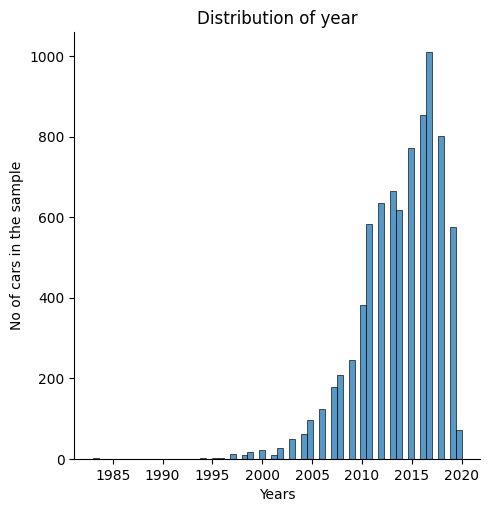

In [23]:
# Explore range of years related to cars in the dataset
sns.displot(data = df, x = 'year')
# Add labels
plt.xlabel("Years")
plt.ylabel("No of cars in the sample")
plt.title("Distribution of year")

plt.show()

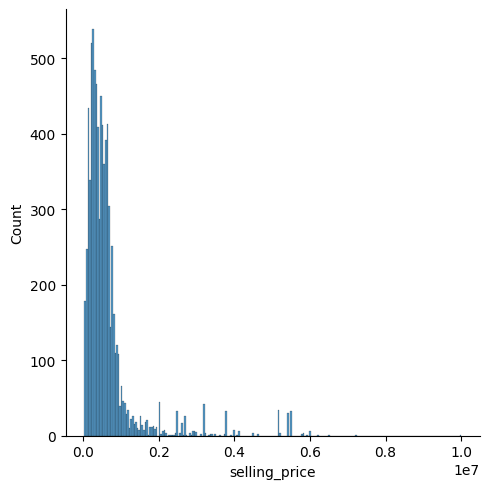

In [24]:
# Explore the distribution of car seling price across the dataset
sns.displot(data = df, x = 'selling_price')

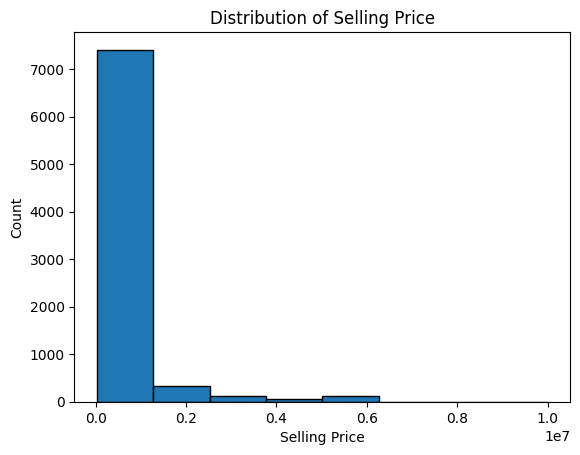

In [25]:
# For clear visualization, plot histogram for "selling_price" with 8 bins
plt.hist(df["selling_price"], bins=8, edgecolor="black")

# Add labels
plt.xlabel("Selling Price")
plt.ylabel("Count")
plt.title("Distribution of Selling Price")

plt.show()

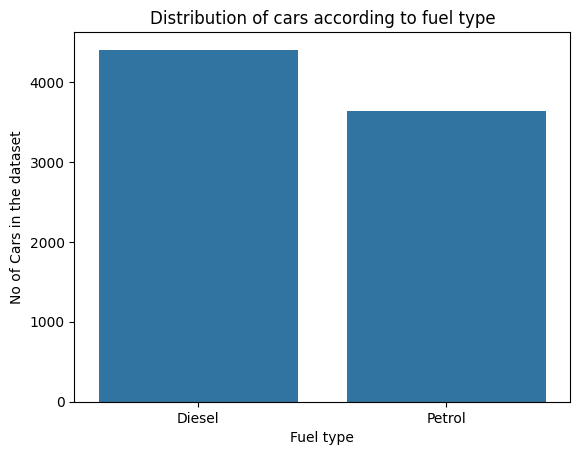

In [26]:
# Explore the distribution of cars in the dataset according to the fuel type across the dataset
sns.countplot(data = df, x = 'fuel')

# Add labels
plt.xlabel("Fuel type")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to fuel type")

plt.show()

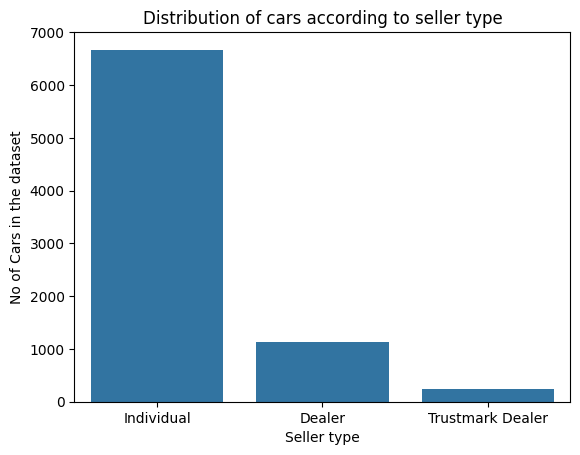

In [27]:
# Explore the distribution of cars in the dataset according to the seller type across the dataset
sns.countplot(data = df, x = 'seller_type')

# Add labels
plt.xlabel("Seller type")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to seller type")

plt.show()

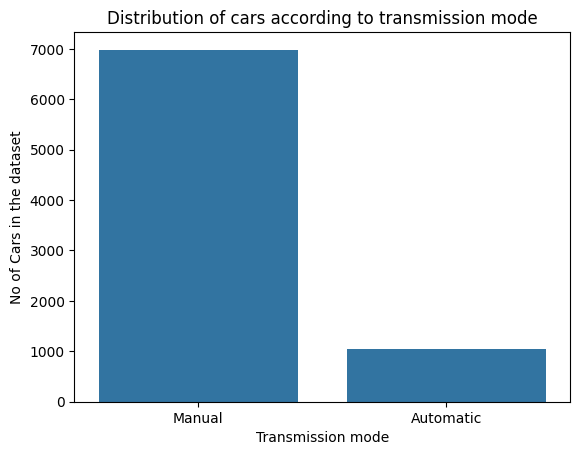

In [28]:
# Explore the distribution of cars in the dataset according to the transmission type across the datasetS
sns.countplot(data = df, x = 'transmission')

# Add labels
plt.xlabel("Transmission mode")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to transmission mode")

plt.show()



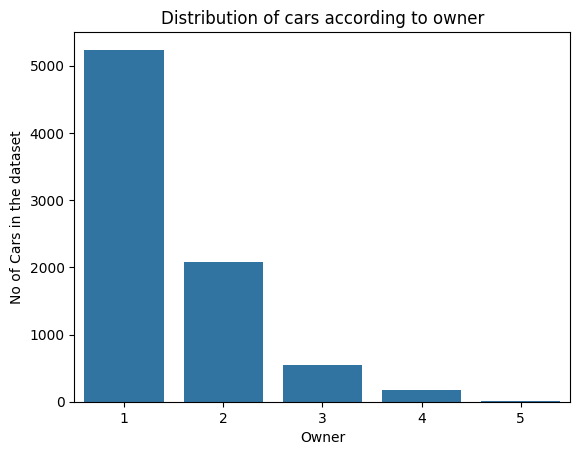

In [29]:
# Explore the distribution of cars in the dataset according to the owner type across the dataset
sns.countplot(data = df, x = 'owner')

# Add labels
plt.xlabel("Owner")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to owner")

plt.show()


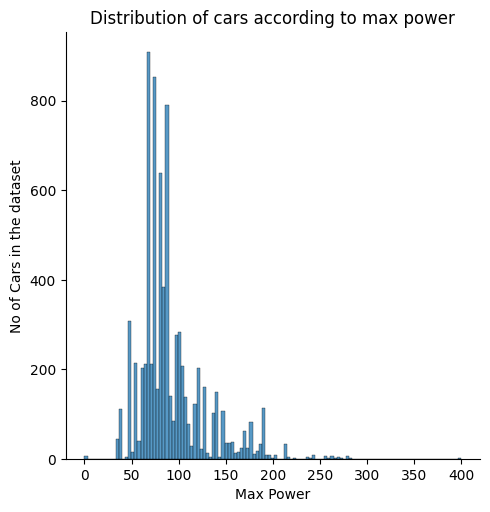

In [30]:
sns.displot(data = df, x = "max_power")

# Add labels
plt.xlabel("Max Power")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to max power")

plt.show()

Multivariant Analysis

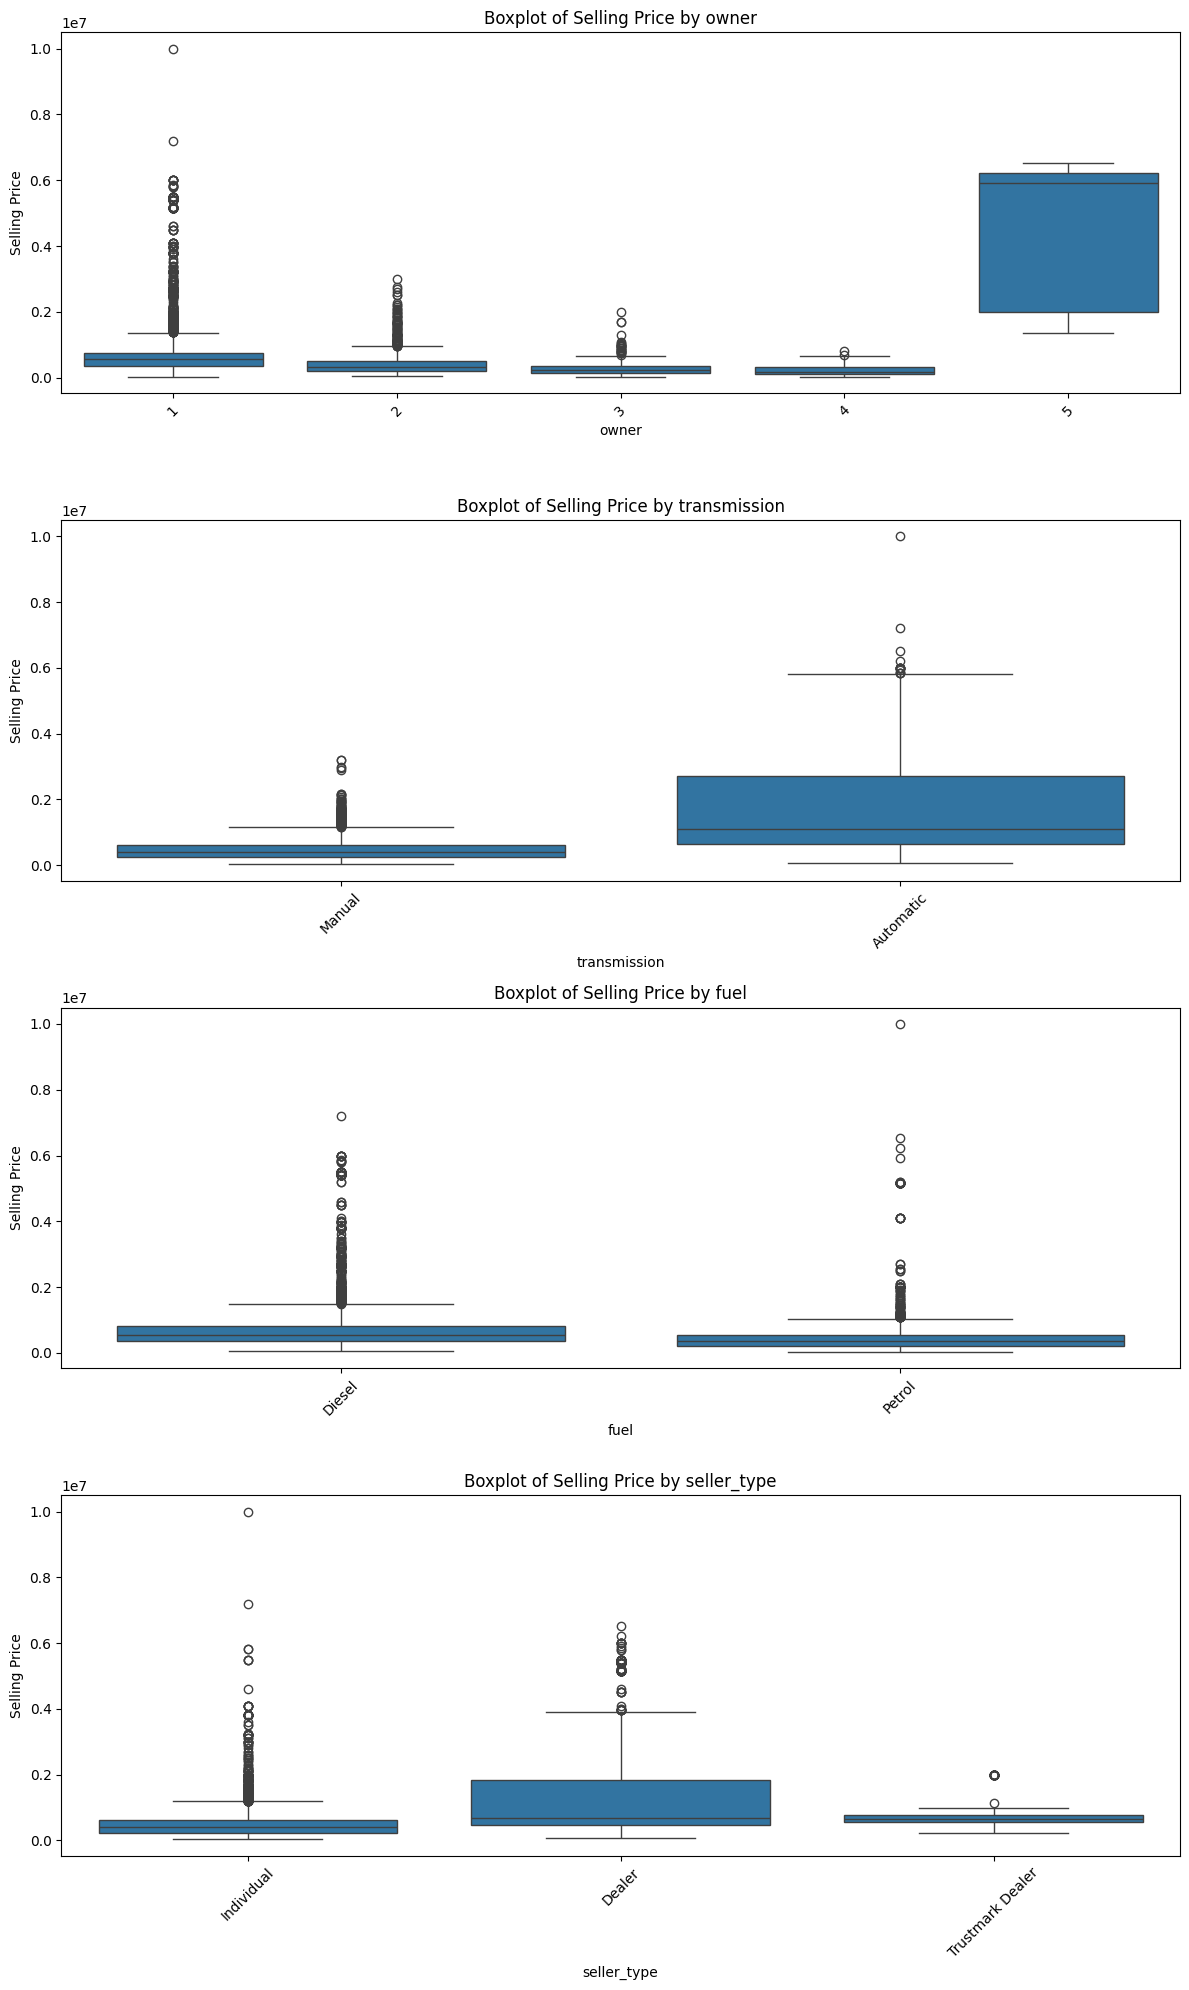

In [31]:
# Explore the relationship between categorical features and selling price using boxplots

import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features to plot
cat_cols = ["owner", "transmission", "fuel", "seller_type"]

# Set up subplot grid
rows = len(cat_cols)
fig, axes = plt.subplots(rows, 1, figsize=(12, rows * 5))  
axes = axes.flatten()

# Iterate through categorical columns and plot boxplots
for i, col in enumerate(cat_cols):
    sns.boxplot(x=df[col], y=df["selling_price"], ax=axes[i])
    axes[i].set_title(f"Boxplot of Selling Price by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Selling Price")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplot spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


<Axes: xlabel='year', ylabel='selling_price'>

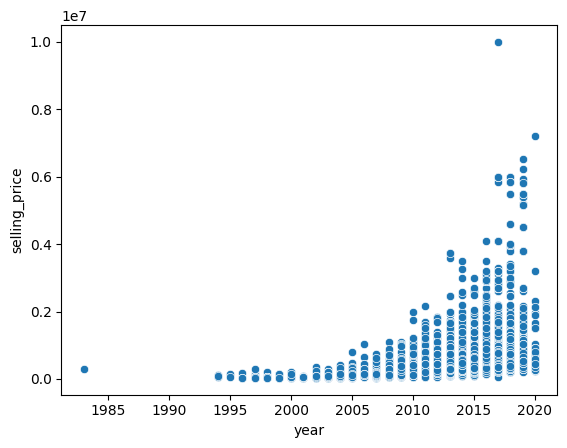

In [32]:
# Explorethe selling price of sample dataset with respect to the year of car manufacturing
sns.scatterplot(x = df['year'], y = df['selling_price'])

<Axes: xlabel='year', ylabel='selling_price'>

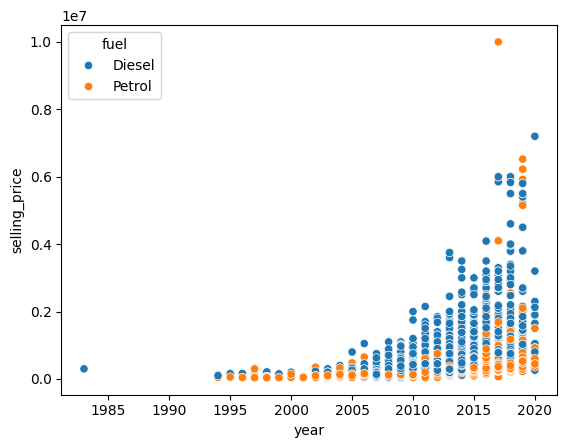

In [33]:
# Explorethe selling price of sample dataset with respect to the year of car manufacturing and fuel type
sns.scatterplot(x = df['year'], y = df['selling_price'], hue=df['fuel'])

<Axes: xlabel='year', ylabel='selling_price'>

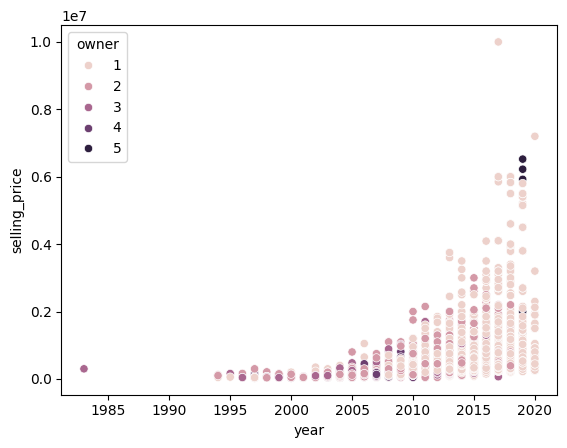

In [34]:
# Explorethe selling price of sample dataset with respect to the year of car manufacturing and owner type
sns.scatterplot(x = df['year'], y = df['selling_price'], hue=df['owner'])

<Axes: xlabel='mileage', ylabel='selling_price'>

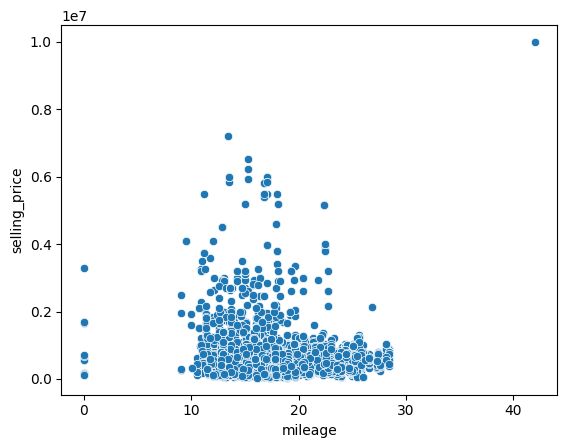

In [35]:
# Explorethe selling price of sample dataset with respect to the mileage of cars
sns.scatterplot(x = df['mileage'], y = df['selling_price'])

Correlation Matrix

Explore strong factors predicting the car price and checking whether certain features are too correlated

In [36]:
# drop the column because Chaky’s company does not understand well about it
df = df.drop('torque', axis='columns')

In [37]:
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0


Label Encoding

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [39]:
unique_values = df['brand'].unique()
print("Unique attributes in 'brand':", unique_values)

Unique attributes in 'brand': ['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota' 'Ford' 'Renault' 'Mahindra'
 'Tata' 'Chevrolet' 'Fiat' 'Datsun' 'Jeep' 'Mercedes-Benz' 'Mitsubishi'
 'Audi' 'Volkswagen' 'BMW' 'Nissan' 'Lexus' 'Jaguar' 'Land' 'MG' 'Volvo'
 'Daewoo' 'Kia' 'Force' 'Ambassador' 'Ashok' 'Isuzu' 'Opel' 'Peugeot']


In [40]:
# one hot encoding better when there are less than 4 - 5 unique features in the column.
# as 'brand' column has 32 unique values, label encoding will be applied

# label encoding for 'brand' column
le = LabelEncoder()
df["brand"] = le.fit_transform(df["brand"])

df["brand"].unique()


array([20, 27, 10, 11, 29,  9, 26, 19, 28,  4,  7,  6, 14, 21, 22,  2, 30,
        3, 23, 17, 13, 16, 18, 31,  5, 15,  8,  0,  1, 12, 24, 25])

In [41]:
# we can call le.classes_ to know what it maps to
le.classes_

array(['Ambassador', 'Ashok', 'Audi', 'BMW', 'Chevrolet', 'Daewoo',
       'Datsun', 'Fiat', 'Force', 'Ford', 'Honda', 'Hyundai', 'Isuzu',
       'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'MG', 'Mahindra',
       'Maruti', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Opel',
       'Peugeot', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen',
       'Volvo'], dtype=object)

In [42]:
# label encoding for 'fuel'
le = LabelEncoder()
df["fuel"] = le.fit_transform(df["fuel"])

df["fuel"].unique()


array([0, 1])

In [43]:
# we can call le.classes_ to know what it maps to
le.classes_

array(['Diesel', 'Petrol'], dtype=object)

In [44]:
# then we can try transform
le.transform(["Diesel", "Petrol"])

array([0, 1])

In [45]:
df["seller_type"].unique()

array(['Individual', 'Dealer', 'Trustmark Dealer'], dtype=object)

In [46]:
df["seller_type"].value_counts()

seller_type
Individual          6673
Dealer              1124
Trustmark Dealer     236
Name: count, dtype: int64

In [47]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Column to encode
col_to_encode = ["seller_type"]

# Initialize encoder
encoder = OneHotEncoder(drop="first", handle_unknown="ignore")

# Fit & transform on the dataset
encoded = encoder.fit_transform(df[col_to_encode])

# Convert back to DataFrame
encoded_df = pd.DataFrame(encoded.toarray(),
                          columns=encoder.get_feature_names_out(col_to_encode),
                          index=df.index)

# Drop original column and join encoded columns
df = pd.concat([df.drop(col_to_encode, axis=1), encoded_df], axis=1)

df.head()




,brand,year,selling_price,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer
0,20,2014,450000,145500,0,Manual,1,23.40,1248.0,74.00,5.0,1.0,0.0
1,27,2014,370000,120000,0,Manual,2,21.14,1498.0,103.52,5.0,1.0,0.0
2,10,2006,158000,140000,1,Manual,3,17.70,1497.0,78.00,5.0,1.0,0.0
3,11,2010,225000,127000,0,Manual,1,23.00,1396.0,90.00,5.0,1.0,0.0
4,20,2007,130000,120000,1,Manual,1,16.10,1298.0,88.20,5.0,1.0,0.0


In [48]:
df.columns

Index(['brand', 'year', 'selling_price', 'km_driven', 'fuel', 'transmission',
       'owner', 'mileage', 'engine', 'max_power', 'seats',
       'seller_type_Individual', 'seller_type_Trustmark Dealer'],
      dtype='object')

In [49]:
# label encoding for 'transmission'
le = LabelEncoder()
df["transmission"] = le.fit_transform(df["transmission"])

df["transmission"].unique() 

array([1, 0])

In [50]:
# we can call le.classes_ to know what it maps to
le.classes_

array(['Automatic', 'Manual'], dtype=object)

In [51]:

le.transform(["Manual", "Automatic"])

array([1, 0])

In [52]:
# According to EDA for owner attribue VS selling price done above, Test Drive Cars are ridiculously expensive. 
# Since we do not want to involve this, we will simply delete all samples related to it.
df = df[df['owner'] != 5]


In [53]:
df.shape

(8028, 13)

<Axes: >

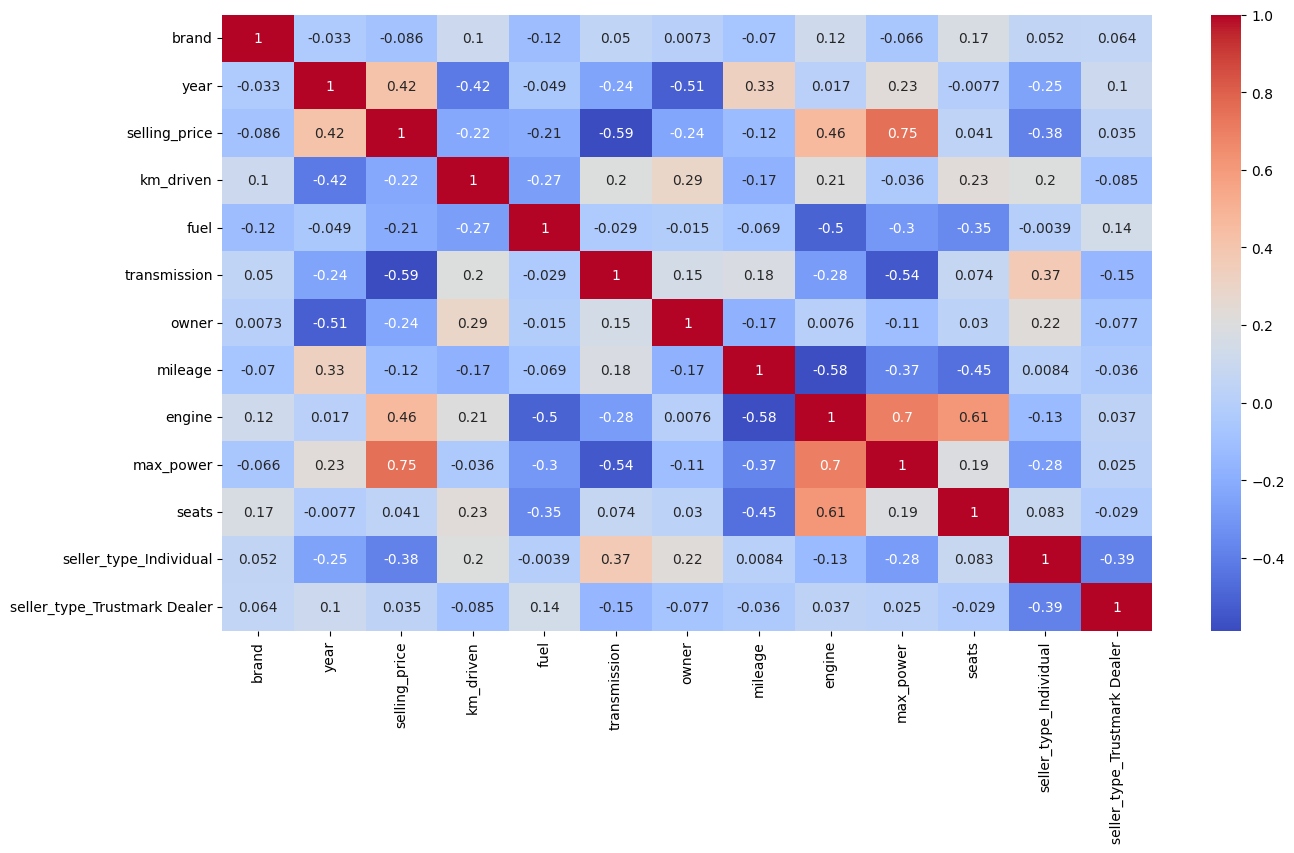

In [54]:
# Let's check out heatmap
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")  


In [55]:
# define X
X = df.drop('selling_price', axis='columns')
# define y
y = df['selling_price']

In [56]:
# split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [57]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5619, 12), (2409, 12), (5619,), (2409,))

In [58]:
X.head()

,brand,year,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer
0,20,2014,145500,0,1,1,23.40,1248.0,74.00,5.0,1.0,0.0
1,27,2014,120000,0,1,2,21.14,1498.0,103.52,5.0,1.0,0.0
2,10,2006,140000,1,1,3,17.70,1497.0,78.00,5.0,1.0,0.0
3,11,2010,127000,0,1,1,23.00,1396.0,90.00,5.0,1.0,0.0
4,20,2007,120000,1,1,1,16.10,1298.0,88.20,5.0,1.0,0.0


In [59]:
# Combine back for easier manual downsampling
df_train = pd.concat([X_train, y_train], axis=1)

df_test = pd.concat([X_test, y_test], axis=1)

In [60]:
df_train.head()

,brand,year,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer,selling_price
6853,4,2015,120000,0,1,1,13.58,2499.0,72.40,10.0,1.0,0.0,434000
1495,19,2013,90000,0,1,2,15.96,2523.0,62.10,7.0,1.0,0.0,400000
7904,20,2013,92000,0,1,3,20.77,1248.0,88.76,7.0,1.0,0.0,500000
1281,28,2010,100000,0,1,2,18.80,1248.0,90.00,5.0,1.0,0.0,190000
1421,11,2010,120000,0,1,3,23.00,1396.0,90.00,5.0,1.0,0.0,215000


In [61]:
df_test.head()

,brand,year,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer,selling_price
5948,28,2011,35000,1,1,1,15.00,1368.0,90.00,5.0,1.0,0.0,225000
6039,11,2016,110000,0,1,1,19.67,1582.0,126.20,5.0,1.0,0.0,900000
3069,20,2015,60000,1,1,1,20.51,998.0,67.04,5.0,1.0,0.0,320000
6531,26,2014,80000,0,1,1,19.01,1461.0,108.45,5.0,1.0,0.0,650000
322,11,2018,29000,0,1,1,24.00,1186.0,73.97,5.0,1.0,0.0,520000


In [62]:
num_bins = 4

bin_edges = pd.cut(df_train['selling_price'], bins=num_bins, retbins=True)[1]  

# Apply binning to training set
df_train['selling_price'] = pd.cut(df_train['selling_price'], 
                                 bins=bin_edges, 
                                 labels=[0, 1, 2, 3], 
                                 include_lowest=True)



In [63]:
# Apply binning using the SAME bin_edges
df_test['selling_price'] = pd.cut(df_test['selling_price'], 
                                bins=bin_edges, 
                                labels=[0, 1, 2, 3], 
                                include_lowest=True)
print(df_test.head())

      brand  year  km_driven  fuel  transmission  owner  mileage  engine  \
5948     28  2011      35000     1             1      1    15.00  1368.0   
6039     11  2016     110000     0             1      1    19.67  1582.0   
3069     20  2015      60000     1             1      1    20.51   998.0   
6531     26  2014      80000     0             1      1    19.01  1461.0   
322      11  2018      29000     0             1      1    24.00  1186.0   

      max_power  seats  seller_type_Individual  seller_type_Trustmark Dealer  \
5948      90.00    5.0                     1.0                           0.0   
6039     126.20    5.0                     1.0                           0.0   
3069      67.04    5.0                     1.0                           0.0   
6531     108.45    5.0                     1.0                           0.0   
322       73.97    5.0                     1.0                           0.0   

     selling_price  
5948             0  
6039             0  

In [64]:
df_train.head()

,brand,year,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer,selling_price
6853,4,2015,120000,0,1,1,13.58,2499.0,72.40,10.0,1.0,0.0,0
1495,19,2013,90000,0,1,2,15.96,2523.0,62.10,7.0,1.0,0.0,0
7904,20,2013,92000,0,1,3,20.77,1248.0,88.76,7.0,1.0,0.0,0
1281,28,2010,100000,0,1,2,18.80,1248.0,90.00,5.0,1.0,0.0,0
1421,11,2010,120000,0,1,3,23.00,1396.0,90.00,5.0,1.0,0.0,0


In [65]:
df_test.head()

,brand,year,km_driven,fuel,transmission,owner,mileage,engine,max_power,seats,seller_type_Individual,seller_type_Trustmark Dealer,selling_price
5948,28,2011,35000,1,1,1,15.00,1368.0,90.00,5.0,1.0,0.0,0
6039,11,2016,110000,0,1,1,19.67,1582.0,126.20,5.0,1.0,0.0,0
3069,20,2015,60000,1,1,1,20.51,998.0,67.04,5.0,1.0,0.0,0
6531,26,2014,80000,0,1,1,19.01,1461.0,108.45,5.0,1.0,0.0,0
322,11,2018,29000,0,1,1,24.00,1186.0,73.97,5.0,1.0,0.0,0


#### Use Correlation Matrix for feature selection

<Axes: >

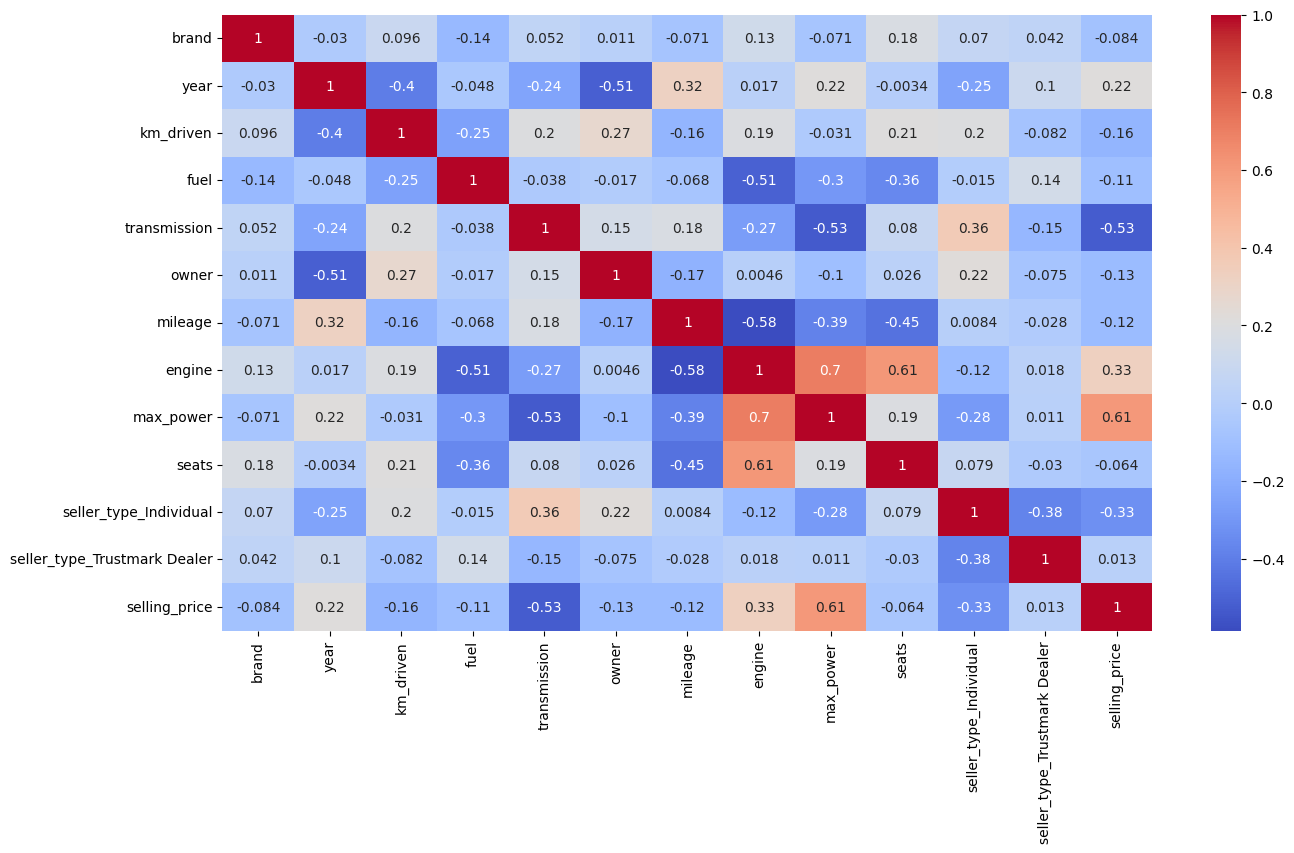

In [66]:
plt.figure(figsize = (15,8))
sns.heatmap(df_train.corr(), annot=True, cmap="coolwarm")  

After bining selling price into 4 classes, still it has higher correlation with 'max_power' and 'transmission'.

#### Check class imbalance

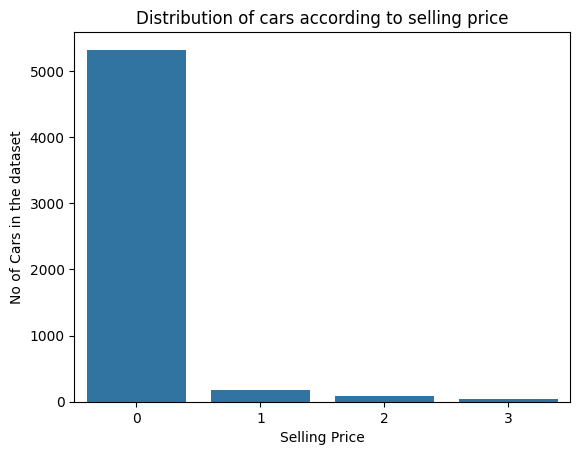

In [67]:
# check the distribution of target classes in training dataset
sns.countplot(data = df_train, x = 'selling_price')
# Add labels
plt.xlabel("Selling Price")
plt.ylabel("No of Cars in the dataset")
plt.title("Distribution of cars according to selling price")
plt.show()

In [68]:
df_train['selling_price'].value_counts()

selling_price
0    5322
1     177
2      86
3      34
Name: count, dtype: int64

As the classes are not imbalance, balance the classes downsampling or upsampling should be done. If we do the downsampling each class may have 34 records for each which will not sufficient to train a model with better accuracy. Therefore, upsampling will be applied to the training dataset.

In here, I will use SMOTE algorithm which dynamically augments data on the fly. From which we can upsample the data for classes as well as avoid data leakage to test dataset during balancing classes records.

How every, if it upsamples, classes like class 3 will have considerable synthetic data as it has initially 34 and highest sample count in the classes is 5322.

Therefore, I will first downsample class 0 to 177 and then upsample the dataset using SMOTE during training process.

In [69]:
# downsample class 0 to match class 1
df_class_0 = df_train[df_train['selling_price'] == 0]
df_class_1 = df_train[df_train['selling_price'] == 1]
df_class_2 = df_train[df_train['selling_price'] == 2]
df_class_3 = df_train[df_train['selling_price'] == 3]
df_class_0_downsampled = df_class_0.sample(n=len(df_class_1), random_state=42)
df_train = pd.concat([df_class_0_downsampled, df_class_1, df_class_2, df_class_3])
df_train['selling_price'].value_counts()

selling_price
0    177
1    177
2     86
3     34
Name: count, dtype: int64

#### 03. Feature Selection

In [70]:
#x is our strong features

X_train = df_train[['transmission','max_power']]
y_train = df_train['selling_price']

X_test = df_test[['transmission','max_power']]
y_test = df_test['selling_price']



In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((474, 2), (2409, 2), (474,), (2409,))

In [72]:
X_train.head(3)

,transmission,max_power
5375,1,67.05
3294,1,68.00
1633,0,103.30


In [73]:
X_test.head(3)

,transmission,max_power
5948,1,90.00
6039,1,126.20
3069,1,67.04


#### 04. Preprocessing

In [74]:
# check null values

#check for null values
X_train[['transmission','max_power']].isna().sum()

transmission    0
max_power       4
dtype: int64

In [75]:
X_test[['transmission','max_power']].isna().sum()

transmission     0
max_power       59
dtype: int64

In [76]:
y_train.isna().sum()

np.int64(0)

In [77]:
y_test.isna().sum()

np.int64(1)

In [78]:
import pickle

# calculate defaults for missing values
mean_max_power = X_train["max_power"].mean()
median_max_power = X_train["max_power"].median()

#  Categorical feature defaults (transmission ratio)
transmission_counts = X_train["transmission"].value_counts(normalize=True).to_dict()

# Save defaults
defaults = {
    "mean_max_power": mean_max_power,
    "median_max_power": median_max_power,
    "transmission_ratio": transmission_counts
}

with open("defaults.pkl", "wb") as f:
    pickle.dump(defaults, f)

print("Defaults saved:", defaults)


Defaults saved: {'mean_max_power': np.float64(148.90670212765957), 'median_max_power': np.float64(168.5), 'transmission_ratio': {0: 0.6371308016877637, 1: 0.3628691983122363}}


In [79]:
## if numbers -->  average | median | regression results | 0
## if categories --> mode     |  ratio    | “No category”

#let's fill the training set first!
X_train['max_power'].fillna(X_train['max_power'].mean(), inplace=True)

In [80]:
#let's fill the testing set
X_test['max_power'].fillna(X_test['max_power'].mean(), inplace=True)

In [81]:
#check again
X_train[['transmission','max_power']].isna().sum()

transmission    0
max_power       0
dtype: int64

In [82]:
X_test[['transmission','max_power']].isna().sum()

transmission    0
max_power       0
dtype: int64

In [83]:
y_train.isna().sum(), y_test.isna().sum()

(np.int64(0), np.int64(1))

In [84]:
y_test.isna().sum()

np.int64(1)

In [85]:
# If y_test is a pandas Series (categorical or otherwise)
mask = y_test.notna()  # True for non-null rows
X_test = X_test[mask]
y_test = y_test[mask]

  # Make sure predictions match

Checking Outliers

In [86]:
def outlier_count(col, data = X_train):
    
    # calculate your 25% quatile and 75% quatile
    q75, q25 = np.percentile(data[col], [75, 25])
    
    # calculate your inter quatile
    iqr = q75 - q25
    
    # min_val and max_val
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    # count number of outliers, which are the data that are less than min_val or more than max_val calculated above
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    
    # calculate the percentage of the outliers
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    
    if(outlier_count > 0):
        print("\n"+15*'-' + col + 15*'-'+"\n")
        print('Number of outliers: {}'.format(outlier_count))
        print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [87]:
for col in X_train.columns:
    outlier_count(col)

### Scalling

In [88]:
# Scale only the second column
scaler = MinMaxScaler()
X_train.iloc[:, 1] = scaler.fit_transform(X_train.iloc[:, [1]])
X_test.iloc[:, 1]  = scaler.transform(X_test.iloc[:, [1]])

In [114]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

#### split the balanced training and testing batch to X and Y

In [89]:
# add intercept to our X
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)  #add intercept
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)  #add intercept

In [90]:
y_train.head(3)

5375    0
3294    0
1633    0
Name: selling_price, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]

In [91]:
# store number of class in k variable
k = len(set(y_train))  
k

4

In [92]:
m = X_train.shape[0]  # no.of samples
n = X_train.shape[1]  # no. of features

In [93]:
print(m,n)

474 3


In [94]:
# Change the target to one-hot encoding

Y_train_encoded = np.zeros((m, k))
for each_class in range(k):
    cond = y_train==each_class
    Y_train_encoded[np.where(cond), each_class] = 1

In [95]:
Y_train_encoded

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], shape=(474, 4))

#### 05. Model Implementation

In [96]:
class LogisticRegression:
    
    def __init__(self, regularization, k, n, method, lr, max_iter=5000):
        self.k = k
        self.n = n
        self.alpha = lr
        self.max_iter = max_iter
        self.method = method
        self.regularization = regularization
    
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k)
        self.losses = []
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                #if i % 500 == 0:
                    #print(f"Loss at iteration {i}", loss)
            #print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                #if i % 500 == 0:
                    #print(f"Loss at iteration {i}", loss)
            #print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "stochastic":
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                #if i % 500 == 0:
                    #print(f"Loss at iteration {i}", loss)
            #print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
        
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        loss = - np.sum(Y*np.log(h)) / m + self.regularization(self.W) /(2*m)
        error = h - Y
        grad = self.softmax_grad(X, error)/m +self.regularization.derivation(self.W)/m
        return loss, grad
    


    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return  X.T @ error

    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

    # Add functions accuracy, precision, recall and f1

    def accuracy(self, X_test, y_true):
        y_pred = self.predict(X_test)
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)
        return np.mean(y_pred == y_true)
    

    def precision(self, X_test, y_true):
        y_pred = self.predict(X_test)
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)
        
        precisions = {}
        for cls in range(self.k):
            TP = np.sum((y_pred == cls) & (y_true == cls))
            FP = np.sum((y_pred == cls) & (y_true != cls))
            precisions[cls] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        return precisions
    
    def recall(self, X_test, y_true):
        y_pred = self.predict(X_test)
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)
        
        recalls = {}
        for cls in range(self.k):
            TP = np.sum((y_pred == cls) & (y_true == cls))
            FN = np.sum((y_pred != cls) & (y_true == cls))
            recalls[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        return recalls
    

    def f1_score(self, X_test, y_true):
        prec = self.precision(X_test, y_true)
        rec = self.recall(X_test, y_true)
        
        f1_scores = {}
        for cls in range(self.k):
            p, r = prec[cls], rec[cls]
            f1_scores[cls] = (2 * p * r) / (p + r) if (p + r) > 0 else 0.0
        return f1_scores
    
    # Add functions macro precision, macro recall and macro f1
    
    def macro_precision(self, X_test, y_true):
        precisions = self.precision(X_test, y_true)  # dict {class: precision}
        return np.mean(list(precisions.values()))

    def macro_recall(self, X_test, y_true):
        recalls = self.recall(X_test, y_true)  # dict {class: recall}
        return np.mean(list(recalls.values()))

    def macro_f1(self, X_test, y_true):
        f1_scores = self.f1_score(X_test, y_true)  # dict {class: f1}
        return np.mean(list(f1_scores.values()))
    
    # Add weighted matrices

    def weighted_precision(self, X_test, y_true):
        # convert class labels to integers
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)

        precisions = self.precision(X_test, y_true)
        weights = [(y_true == cls).sum() / len(y_true) for cls in range(self.k)]
        return sum(weights[cls] * precisions[cls] for cls in range(self.k))

    def weighted_recall(self, X_test, y_true):
        # convert class labels to integers
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)

        recalls = self.recall(X_test, y_true)
        weights = [(y_true == cls).sum() / len(y_true) for cls in range(self.k)]
        return sum(weights[cls] * recalls[cls] for cls in range(self.k))
    
    def weighted_f1(self, X_test, y_true):
        # convert class labels to integers
        if len(y_true.shape) > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)

        f1_scores = self.f1_score(X_test, y_true)
        weights = [(y_true == cls).sum() / len(y_true) for cls in range(self.k)]
        return sum(weights[cls] * f1_scores[cls] for cls in range(self.k))


#### Add ridge regression

In [97]:
#Ridge
class Ridge:
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
    
    def derivation(self, theta):
        return self.l * 2 * theta
    

class RidgeRegression(LogisticRegression):
    def __init__(self, k, n, method="minibatch",lr=0.01,l=0.001):
        self.regularization = Ridge(l)
        self, k, n, method
        super().__init__(self.regularization, k, n, method,lr)

#### Model training

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np

k_folds = 5
smote = SMOTE(random_state=42)
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# to sure y_train is 1D integer labels (not one-hot)
y_train = np.array(y_train)
Y_train_encoded = np.array(Y_train_encoded)
    


In [99]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [ ]:
import mlflow
import mlflow.sklearn
from itertools import product
import numpy as np
import pickle

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_experiment("st126489-a3")

# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    "reg_lambda": [0.01, 0.1, 1],
    "method": ["stochastic", "minibatch", "batch"]
}

best_acc = 0
best_params = None

# Loop over all combinations
for lr, reg, method in product(param_grid["learning_rate"], param_grid["reg_lambda"], param_grid["method"]):
    run_name = f"lr-{lr}_reg-{reg}_method-{method}"
    
    with mlflow.start_run(run_name=run_name, nested=True):
        print(f"\n===== Running {run_name} =====")
        fold_accs = []
        fold_f1s = []
        fold_precision = []
        fold_recall = []

        # performing cross validation
        for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            Y_tr, Y_val = Y_train_encoded[train_idx], Y_train_encoded[val_idx]

            # SMOTE
            X_res, y_res = smote.fit_resample(X_tr, y_tr)

            # Recreate one-hot
            k = Y_train_encoded.shape[1]
            Y_res = np.zeros((len(y_res), k))
            for c in range(k):
                Y_res[np.where(y_res == c), c] = 1

            # Train model
            model = RidgeRegression(k=k, n=X_train.shape[1], method=method,
                                    lr=lr, l=reg)
            model.fit(X_res, Y_res)

            # Evaluate metrics
            acc = model.accuracy(X_val, Y_val)
            f1 = model.macro_f1(X_val, Y_val)
            prec = model.macro_precision(X_val, Y_val)
            rec = model.macro_recall(X_val, Y_val)

            fold_accs.append(acc)
            fold_f1s.append(f1)
            fold_precision.append(prec)
            fold_recall.append(rec)

        # Compute mean metrics across folds
        mean_acc = np.mean(fold_accs)
        mean_f1 = np.mean(fold_f1s)
        mean_prec = np.mean(fold_precision)
        mean_rec = np.mean(fold_recall)

        print(f"Mean Accuracy: {mean_acc:.3f}, F1: {mean_f1:.3f}, Precision: {mean_prec:.3f}, Recall: {mean_rec:.3f}")

        # Log parameters and metrics
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("reg_lambda", reg)
        mlflow.log_param("method", method)
        mlflow.log_metric("mean_accuracy", mean_acc)
        mlflow.log_metric("mean_macro_f1", mean_f1)
        mlflow.log_metric("mean_macro_precision", mean_prec)
        mlflow.log_metric("mean_macro_recall", mean_rec)

        # Save model in MLflow
        # Log the trained model as artifact
        with open("model.pkl", "wb") as f:
            pickle.dump(model, f)
        mlflow.log_artifact("model.pkl")
        #mlflow.sklearn.log_model(model, "model")

        # track best model locally
        if mean_acc > best_acc:
            best_acc = mean_acc
            best_params = {"learning_rate": lr, "reg_lambda": reg, "method": method}
            with open("best_ridge_model.pkl", "wb") as f:
                pickle.dump(model, f)

print("\nBest Params:", best_params)
print("Best Accuracy:", best_acc)



===== Running lr-0.001_reg-0.01_method-stochastic =====
Mean Accuracy: 0.464, F1: 0.320, Precision: 0.322, Recall: 0.459
🏃 View run lr-0.001_reg-0.01_method-stochastic at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/739780227646070692/runs/d80448f91bd44eeba2345041527228fd
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/739780227646070692

===== Running lr-0.001_reg-0.01_method-minibatch =====
Mean Accuracy: 0.072, F1: 0.033, Precision: 0.018, Recall: 0.250
🏃 View run lr-0.001_reg-0.01_method-minibatch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/739780227646070692/runs/bd99728ee1b84d95a20b9d900ea8675f
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/739780227646070692

===== Running lr-0.001_reg-0.01_method-batch =====
Mean Accuracy: 0.513, F1: 0.330, Precision: 0.300, Recall: 0.470
🏃 View run lr-0.001_reg-0.01_method-batch at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/739780227646070692/runs/8090a356f3b5427fa950839

#### Load the best model

In [101]:
with open("best_ridge_model.pkl", "rb") as f:
    best_model = pickle.load(f)


#### Test the model

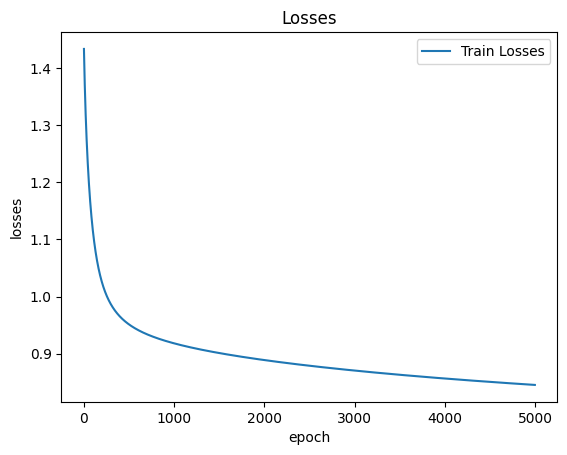

In [102]:
yhat_test = best_model.predict(X_test)

best_model.plot()


#### Evaluate the Model

In [103]:
# Accuracy
acc = best_model.accuracy(X_test, y_test)

# Get per-class metrics
precisions = best_model.precision(X_test, y_test)
recalls = best_model.recall(X_test, y_test)
f1_scores = best_model.f1_score(X_test, y_test)

# Macro
macro_prec = best_model.macro_precision(X_test, y_test)
macro_rec = best_model.macro_recall(X_test, y_test)
macro_f1 = best_model.macro_f1(X_test, y_test)

# Weighted averages
weighted_prec = best_model.weighted_precision(X_test, y_test)
weighted_rec = best_model.weighted_recall(X_test, y_test)
weighted_f1 = best_model.weighted_f1(X_test, y_test)

# Support: number of true samples per class
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true_labels = np.argmax(y_test, axis=1)
else:
    y_true_labels = y_test
classes = sorted(np.unique(y_true_labels))
support = [np.sum(y_true_labels == cls) for cls in classes]



In [104]:
# Print report
print("Report:                precision    recall  f1-score   support\n")
for i, cls in enumerate(classes):
    print(f"           {cls}       {precisions[cls]:.2f}      {recalls[cls]:.2f}      {f1_scores[cls]:.2f}        {support[i]}")
print(f"\n    accuracy                           {acc:.2f}       {len(y_true_labels)}")
print(f"   macro avg       {macro_prec:.2f}      {macro_rec:.2f}      {macro_f1:.2f}       {len(y_true_labels)}")
print(f"weighted avg       {weighted_prec:.2f}      {weighted_rec:.2f}      {weighted_f1:.2f}       {len(y_true_labels)}")

Report:                precision    recall  f1-score   support

           0       1.00      0.93      0.96        2272
           1       0.29      0.70      0.41        87
           2       0.49      0.63      0.55        38
           3       0.10      0.27      0.15        11

    accuracy                           0.91       2408
   macro avg       0.47      0.63      0.52       2408
weighted avg       0.96      0.91      0.93       2408


=========Using Classification Report function=======
Report:                precision    recall  f1-score   support

           0       1.00      0.93      0.96      2272
           1       0.29      0.70      0.41        87
           2       0.49      0.63      0.55        38
           3       0.10      0.27      0.15        11

    accuracy                           0.91      2408
   macro avg       0.47      0.63      0.52      2408
weighted avg       0.96      0.91      0.93      2408



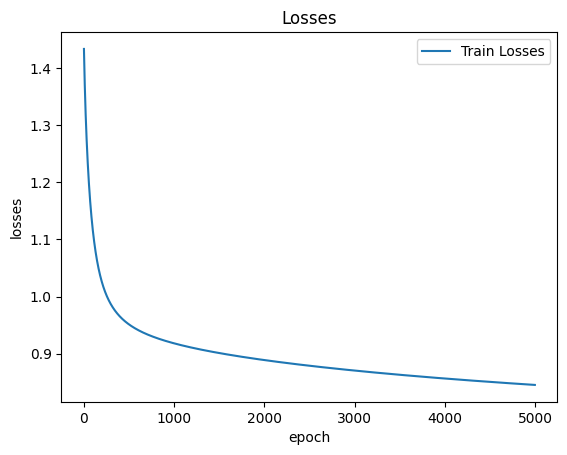

In [105]:
# compare above results with classification report
print("=========Using Classification Report function=======")
print("Report: ", classification_report(y_test, yhat_test))

best_model.plot()

From above results it is clear that scikit-learn classification report and the implemented code to estimate the model performance are same.

Support in the classification report means that the number of true instances of each class in the dataset.

Therefore each class has follwing number of true samples in the test dataset:
Class 0: 2272
Class 1: 87
Class 2: 38
Class 3: 11

#### Analyze feature importance

In [106]:
print(dir(best_model))

['W', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'accuracy', 'alpha', 'f1_score', 'fit', 'gradient', 'h_theta', 'k', 'losses', 'macro_f1', 'macro_precision', 'macro_recall', 'max_iter', 'method', 'n', 'plot', 'precision', 'predict', 'recall', 'regularization', 'softmax', 'softmax_grad', 'weighted_f1', 'weighted_precision', 'weighted_recall']


     Feature  Importance
2  Feature 2    3.425829
1  Feature 1    2.040386
0  Feature 0    1.379142


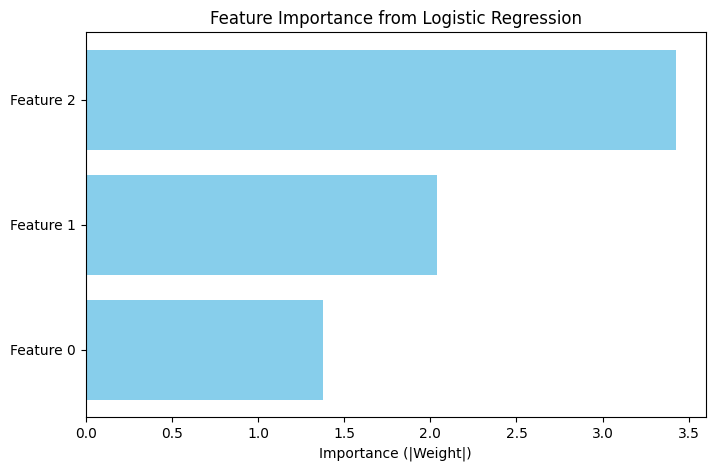

In [107]:
import matplotlib.pyplot as plt

# Get weights from the model
weights = best_model.W  # shape: (num_features, num_classes)

# For multi-class, average absolute weights across classes
if weights.ndim > 1:
    importance = np.mean(np.abs(weights), axis=1)
else:
    importance = np.abs(weights)

# Create a DataFrame for readability
feat_importance = pd.DataFrame({
    'Feature': X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])],
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

# Plot
plt.figure(figsize=(8,5))
plt.barh(feat_importance['Feature'], feat_importance['Importance'], color='skyblue')
plt.xlabel("Importance (|Weight|)")
plt.title("Feature Importance from Logistic Regression")
plt.gca().invert_yaxis()
plt.show()


#### Inference

In [108]:
df_train.iloc[10]

brand                             10.0
year                            2019.0
km_driven                       1303.0
fuel                               1.0
transmission                       1.0
owner                              1.0
mileage                           17.8
engine                          1198.0
max_power                         86.7
seats                              5.0
seller_type_Individual             0.0
seller_type_Trustmark Dealer       0.0
selling_price                      0.0
Name: 130, dtype: float64

In [110]:
sample = np.array([[1,1, 86.7]])

In [111]:
predicted_car_price = best_model.predict(sample)
predicted_car_price


array([3])

#### Discussion

This assignment is about mutli-class classification where the dataset is in 4 categories; class 0, class 1, class 2 and class 3. As shown in the inference phase, for the considered sample, classified class should be 0. But it has been predicted as class 3 even from the best model.Therefore, model should be improved further hyperparameter tuning using different initialization methods for initial weights and appling momentum gor gradient changes etc.

Initially, the classes were imbalanced. I used SMOTE for class imbalance where it will upsample data for minority class during the training of the models. 

Experiment was logged to the CSIM ML flow server and register the best model to the ‘Models’ in the MLflow. The registered model is avaiable there as st126489-a3-model. Following figures shows that there were 27 numbers of models implemented in the experiment and the models have benn sorted in descending with respect to mean_accuracy.

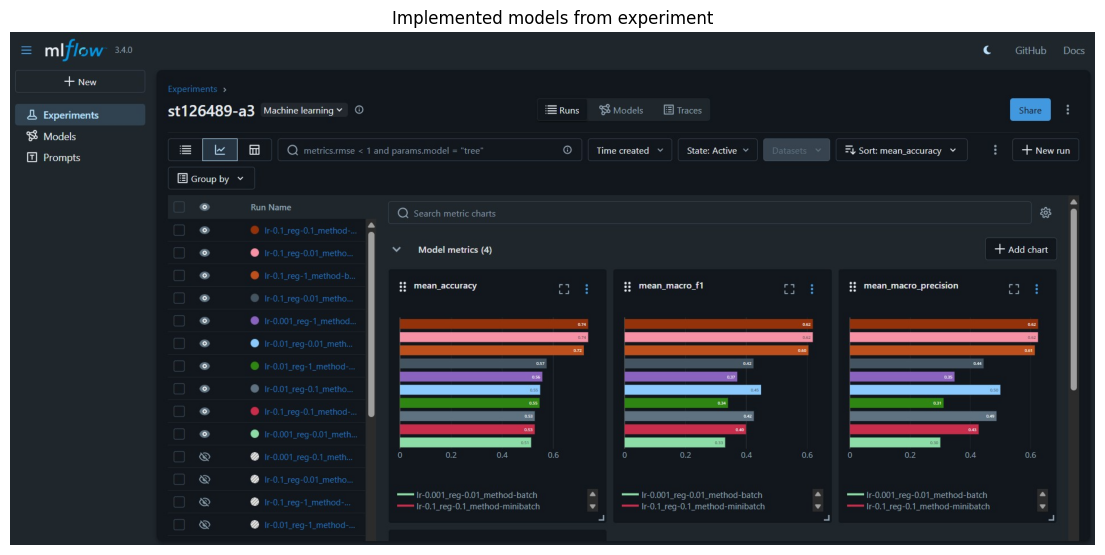

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image 
image_path = "./Screenshot/Mean_accuracy_of models.jpg"  
img = mpimg.imread(image_path)

# Display image
plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.title("Implemented models from experiment")
plt.axis('off')  # turn off axes
plt.show()


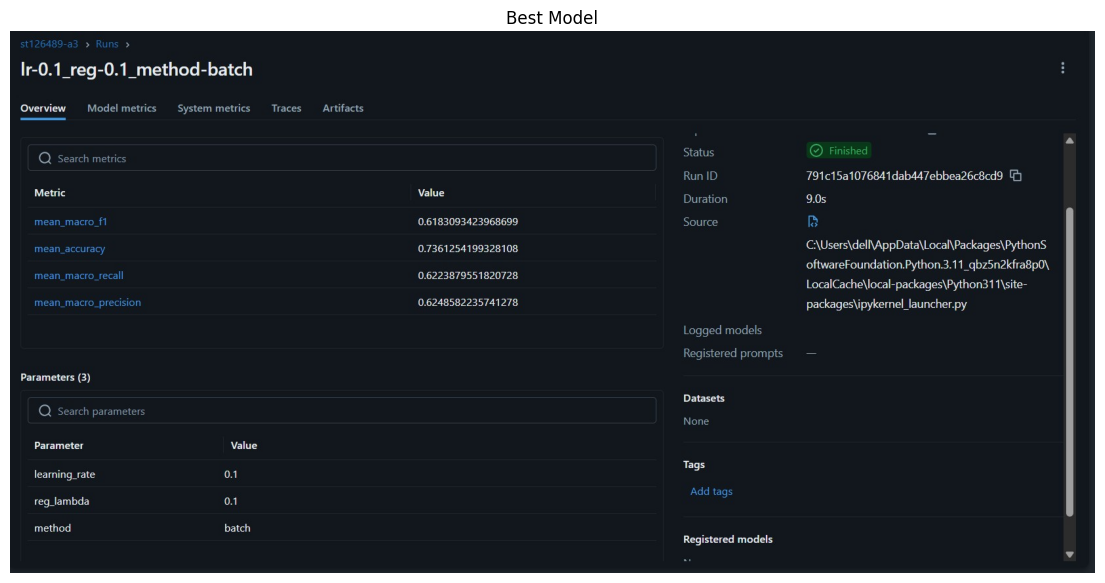

In [8]:
# Load image 
image_path = "./Screenshot/best_model.jpg"  
img = mpimg.imread(image_path)

# Display image
plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.title("Best Model")
plt.axis('off')  # turn off axes
plt.show()

lr=0.1 and reg_lambda = 0.01 for batch method also have the accuracy of best model. Therefore, we can select one of them as the best model for testing and deployment.

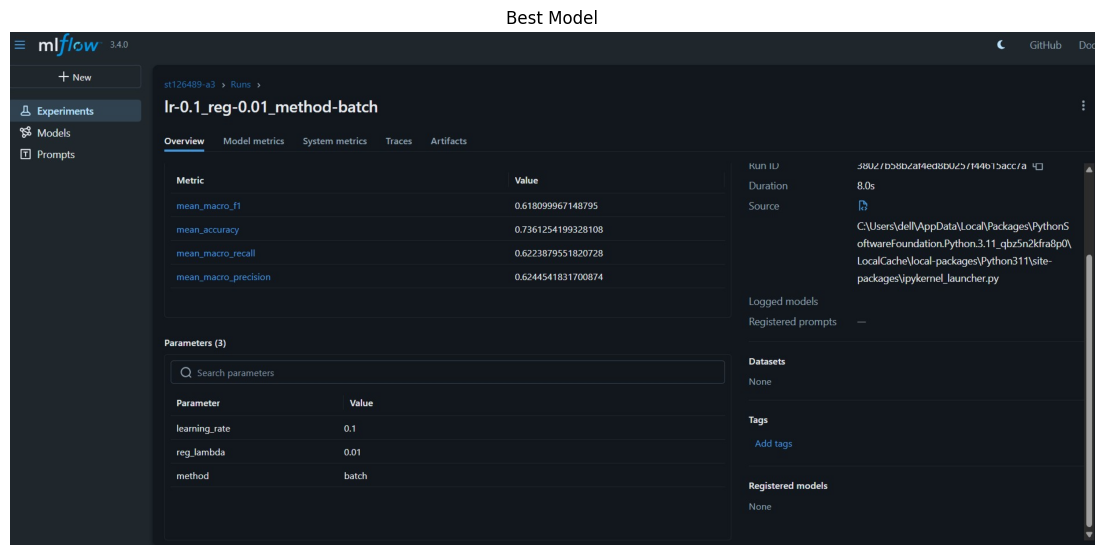

In [10]:
# Load image 
image_path = "./Screenshot/best_model_2.jpg"  
img = mpimg.imread(image_path)

# Display image
plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.title("Best Model")
plt.axis('off')  # turn off axes
plt.show()

For the unit testing of the web application (implemented in appp.py), there is a seperate code implemetation here  which is named "test.py". It is used to check whether all the fuctions in the web application is working as expected.

#### Github Link